In [22]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2


def filtering_2d(image, kernel, sobel=False):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # Calculate the output dimensions
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1
    
    # Initialize the output matrix
    output = np.zeros((output_height, output_width))
    
    # Apply convolution (slide the kernel over the image)
    for i in range(output_height):
        for j in range(output_width):
            # Element-wise multiplication and sum
            total_sum = np.sum(image[i:i+kernel_height, j:j+kernel_width] * kernel)
            output[i, j] = total_sum if sobel == False else abs(total_sum)
    
    return output

def get_x_derivative(img_matrix, kernel):
    pass


def get_y_derivative(img_matrix, kernel):
    pass


def get_grad_mag():
    pass


def get_grad_angle(matrix_a, matrix_b):
    pass

In [ ]:
group_img = Image.open("dataset/group-photo.jpeg")
gray_group_img = group_img.convert('L')

# Convert the image to a NumPy array
img_matrix = np.array(gray_group_img)

# Display the shape and type of the array
print(img_matrix.shape)
print(img_matrix.dtype)
print("img_matrix", img_matrix) 


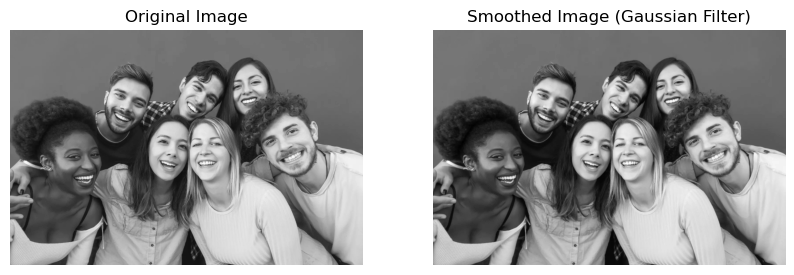

In [23]:
# step 1: Apply Gaussian smoothing on the image.
gaussian_kernel = (1/16) * np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
gaussian_blur_custom = filtering_2d(img_matrix, gaussian_kernel)
gaussian_blur_cv2 = cv2.GaussianBlur(img_matrix,(3,3),0)

# print("gaussian_filtering", gaussian_blur_custom, gaussian_blur_custom.shape)

plt.figure(figsize=(10, 5))
# Original image
plt.subplot(1, 2, 1)
plt.imshow(img_matrix, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Smoothed image
plt.subplot(1, 2, 2)
plt.imshow(gaussian_blur_custom, cmap='gray')
plt.title('Smoothed Image (Gaussian Filter)')
plt.axis('off')

# Smoothed image cv2
# plt.subplot(1, 2, 2)
# plt.imshow(gaussian_blur_cv2, cmap='gray')
# plt.title('Smoothed Image (Gaussian Filter)')
# plt.axis('off')

plt.show()

gradient_x [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [28. 29. 22. ...  0.  0.  0.]
 [28. 27. 11. ...  0.  0.  0.]
 [28. 25.  3. ...  0.  0.  0.]]
gradient_y [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [4. 4. 4. ... 0. 0. 0.]
 ...
 [0. 1. 8. ... 0. 0. 0.]
 [0. 1. 7. ... 0. 0. 0.]
 [0. 1. 5. ... 0. 0. 0.]]


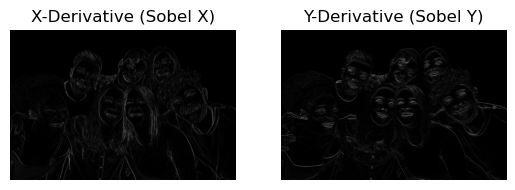

In [24]:
# step 2: Get X, and Y Derivatives using Sobel operator

kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

gradient_x = filtering_2d(img_matrix, kernel_x, True)
gradient_y = filtering_2d(img_matrix, kernel_y, True)

print("gradient_x", gradient_x)
print("gradient_y", gradient_y)

# X-derivative
plt.subplot(1, 2, 1)
plt.imshow(gradient_x, cmap="gray")
plt.title("X-Derivative (Sobel X)")
plt.axis("off")

# Y-derivative
plt.subplot(1, 2, 2)
plt.imshow(gradient_y, cmap="gray")
plt.title("Y-Derivative (Sobel Y)")
plt.axis("off")

plt.show()

# # Apply Gaussian smoothing
# smoothed_image = cv2.GaussianBlur(img_matrix, (3, 3), 0)

# # Compute the x and y derivatives using Sobel filters
# gradient_x = cv2.Sobel(smoothed_image, cv2.CV_64F, 1, 0, ksize=3)
# gradient_y = cv2.Sobel(smoothed_image, cv2.CV_64F, 0, 1, ksize=3)

# # Convert gradients to 8-bit images for displaying
# gradient_x = cv2.convertScaleAbs(gradient_x)
# gradient_y = cv2.convertScaleAbs(gradient_y)

# # Plot the original, smoothed, x-derivative, and y-derivative images
# plt.figure(figsize=(15, 5))


# # X-derivative
# plt.subplot(1, 2, 1)
# plt.imshow(gradient_x, cmap='gray')
# plt.title('X-Derivative (Sobel X)')
# plt.axis('off')

# # Y-derivative
# plt.subplot(1, 2, 2)
# plt.imshow(gradient_y, cmap='gray')
# plt.title('Y-Derivative (Sobel Y)')
# plt.axis('off')

# plt.show()